In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from google.colab import files
import io
import re

In [2]:
# Upload the dataset
uploaded = files.upload()

Saving PPG-BP dataset.xlsx to PPG-BP dataset.xlsx


In [5]:
# Load dataset
# Assuming "Table 1.xlsx" contains clinical metadata and PPG data is stored separately
clinical_data = pd.read_excel(list(uploaded.keys())[0])

In [6]:
print("Columns in the dataset:", clinical_data.columns)
print(clinical_data.head())

Columns in the dataset: Index(['Num.', 'subject_ID', 'Sex(M/F)', 'Age(year)', 'Height(cm)',
       'Weight(kg)', 'Systolic Blood Pressure(mmHg)',
       'Diastolic Blood Pressure(mmHg)', 'Heart Rate(b/m)', 'BMI(kg/m^2)',
       'Hypertension', 'Diabetes', 'cerebral infarction',
       'cerebrovascular disease'],
      dtype='object')
   Num.  subject_ID Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
0     1           2   Female         45         152          63   
1     2           3   Female         50         157          50   
2     3           6   Female         47         150          47   
3     4           8     Male         45         172          65   
4     5           9   Female         46         155          65   

   Systolic Blood Pressure(mmHg)  Diastolic Blood Pressure(mmHg)  \
0                            161                              89   
1                            160                              93   
2                            101                         

In [7]:
# Upload multiple PPG signal files
uploaded_ppg_files = files.upload()

# Create a mapping of filenames to their contents
ppg_file_data = {filename: np.loadtxt(io.BytesIO(content)) for filename, content in uploaded_ppg_files.items()}

Saving 9_1.txt to 9_1.txt
Saving 9_2.txt to 9_2.txt
Saving 9_3.txt to 9_3.txt
Saving 90_1.txt to 90_1.txt
Saving 90_2.txt to 90_2.txt
Saving 90_3.txt to 90_3.txt
Saving 91_1.txt to 91_1.txt
Saving 91_2.txt to 91_2.txt
Saving 91_3.txt to 91_3.txt
Saving 92_1.txt to 92_1.txt
Saving 92_2.txt to 92_2.txt
Saving 92_3.txt to 92_3.txt
Saving 93_1.txt to 93_1.txt
Saving 93_2.txt to 93_2.txt
Saving 93_3.txt to 93_3.txt
Saving 95_1.txt to 95_1.txt
Saving 95_2.txt to 95_2.txt
Saving 95_3.txt to 95_3.txt
Saving 96_1.txt to 96_1.txt
Saving 96_2.txt to 96_2.txt
Saving 96_3.txt to 96_3.txt
Saving 97_1.txt to 97_1.txt
Saving 97_2.txt to 97_2.txt
Saving 97_3.txt to 97_3.txt
Saving 98_1.txt to 98_1.txt
Saving 98_2.txt to 98_2.txt
Saving 98_3.txt to 98_3.txt
Saving 99_1.txt to 99_1.txt
Saving 99_2.txt to 99_2.txt
Saving 99_3.txt to 99_3.txt
Saving 6_1.txt to 6_1.txt
Saving 6_2.txt to 6_2.txt
Saving 6_3.txt to 6_3.txt
Saving 8_1.txt to 8_1.txt
Saving 8_2.txt to 8_2.txt
Saving 8_3.txt to 8_3.txt
Saving 66_

In [8]:
# Normalize filenames to match `subject_ID`
ppg_file_mapping = {}
for filename in uploaded_ppg_files.keys():
    # Extract the base ID from the filename (e.g., '9_1' -> '9')
    base_id = re.match(r"(\d+)", filename).group(1)
    if base_id not in ppg_file_mapping:
        ppg_file_mapping[base_id] = []
    ppg_file_mapping[base_id].append(filename)

In [9]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


In [10]:
# Feature Extraction
def extract_features(ppg_signal, sampling_rate=1000):
    """Extracts time-domain and frequency-domain features from a PPG signal."""
    features = {
        'mean': np.mean(ppg_signal),
        'std': np.std(ppg_signal),
        'max': np.max(ppg_signal),
        'min': np.min(ppg_signal),
        'range': np.max(ppg_signal) - np.min(ppg_signal)
    }
    return features

In [11]:
print(clinical_data.columns)

Index(['Num.', 'subject_ID', 'Sex(M/F)', 'Age(year)', 'Height(cm)',
       'Weight(kg)', 'Systolic Blood Pressure(mmHg)',
       'Diastolic Blood Pressure(mmHg)', 'Heart Rate(b/m)', 'BMI(kg/m^2)',
       'Hypertension', 'Diabetes', 'cerebral infarction',
       'cerebrovascular disease'],
      dtype='object')


In [12]:
print("Uploaded PPG files:", uploaded_ppg_files.keys())


Uploaded PPG files: dict_keys(['9_1.txt', '9_2.txt', '9_3.txt', '90_1.txt', '90_2.txt', '90_3.txt', '91_1.txt', '91_2.txt', '91_3.txt', '92_1.txt', '92_2.txt', '92_3.txt', '93_1.txt', '93_2.txt', '93_3.txt', '95_1.txt', '95_2.txt', '95_3.txt', '96_1.txt', '96_2.txt', '96_3.txt', '97_1.txt', '97_2.txt', '97_3.txt', '98_1.txt', '98_2.txt', '98_3.txt', '99_1.txt', '99_2.txt', '99_3.txt', '6_1.txt', '6_2.txt', '6_3.txt', '8_1.txt', '8_2.txt', '8_3.txt', '66_3.txt', '67_1.txt', '67_2.txt', '67_3.txt', '83_1.txt', '83_2.txt', '83_3.txt', '84_1.txt', '84_2.txt', '84_3.txt', '85_1.txt', '85_2.txt', '85_3.txt', '86_1.txt', '86_2.txt', '86_3.txt', '87_1.txt', '87_2.txt', '87_3.txt', '88_1.txt', '88_2.txt', '88_3.txt', '89_1.txt', '89_2.txt', '89_3.txt', '55_3.txt', '56_1.txt', '56_2.txt', '56_3.txt', '57_1.txt', '57_2.txt', '57_3.txt', '58_1.txt', '58_2.txt', '58_3.txt', '60_1.txt', '60_2.txt', '60_3.txt', '61_1.txt', '61_2.txt', '61_3.txt', '62_1.txt', '62_2.txt', '62_3.txt', '63_1.txt', '63_2.

In [13]:
# Load and preprocess PPG data
ppg_data = []  # List to hold extracted features
labels = []  # Systolic and diastolic BP
sampling_rate = 1000  # 1 kHz
# Assuming PPG data files are referenced by 'subject_ID' or similar
for _, row in clinical_data.iterrows():
    systolic = row["Systolic Blood Pressure(mmHg)"]
    diastolic = row["Diastolic Blood Pressure(mmHg)"]
    subject_id = str(int(row["subject_ID"]))  # Ensure `subject_ID` matches string format

    # Check if files exist for the given `subject_ID`
    if subject_id in ppg_file_mapping:
        # Combine signals from multiple files (e.g., `_1`, `_2`, `_3`) if needed
        combined_signal = []
        for file in ppg_file_mapping[subject_id]:
            signal = np.loadtxt(io.BytesIO(uploaded_ppg_files[file]))
            combined_signal.extend(signal)  # Concatenate signals
        combined_signal = np.array(combined_signal)

        # Process the combined signal
        filtered_signal = bandpass_filter(combined_signal, 0.5, 12, sampling_rate)
        features = extract_features(filtered_signal)
        ppg_data.append(features)
        labels.append((systolic, diastolic))
    else:
        print(f"No files found for subject_ID: {subject_id}. Skipping.")

In [14]:
# Convert to DataFrame
ppg_features = pd.DataFrame(ppg_data)
labels = pd.DataFrame(labels, columns=["Systolic_BP", "Diastolic_BP"])


In [15]:
# Combine features and metadata
full_data = pd.concat([ppg_features, clinical_data[["Age(year)", "Height(cm)", "Weight(kg)", "BMI(kg/m^2)"]]], axis=1)

In [16]:
# Normalize data
scaler = StandardScaler()
full_data_normalized = scaler.fit_transform(full_data)


In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(full_data_normalized, labels, test_size=0.2, random_state=42)

# Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


In [18]:
# Evaluation
rmse_systolic = np.sqrt(mean_squared_error(y_test["Systolic_BP"], y_pred[:, 0]))
mae_systolic = mean_absolute_error(y_test["Systolic_BP"], y_pred[:, 0])

rmse_diastolic = np.sqrt(mean_squared_error(y_test["Diastolic_BP"], y_pred[:, 1]))
mae_diastolic = mean_absolute_error(y_test["Diastolic_BP"], y_pred[:, 1])

print(f"Systolic BP - RMSE: {rmse_systolic}, MAE: {mae_systolic}")
print(f"Diastolic BP - RMSE: {rmse_diastolic}, MAE: {mae_diastolic}")



Systolic BP - RMSE: 16.08531070432105, MAE: 12.572500000000003
Diastolic BP - RMSE: 9.371714090816045, MAE: 7.355227272727273


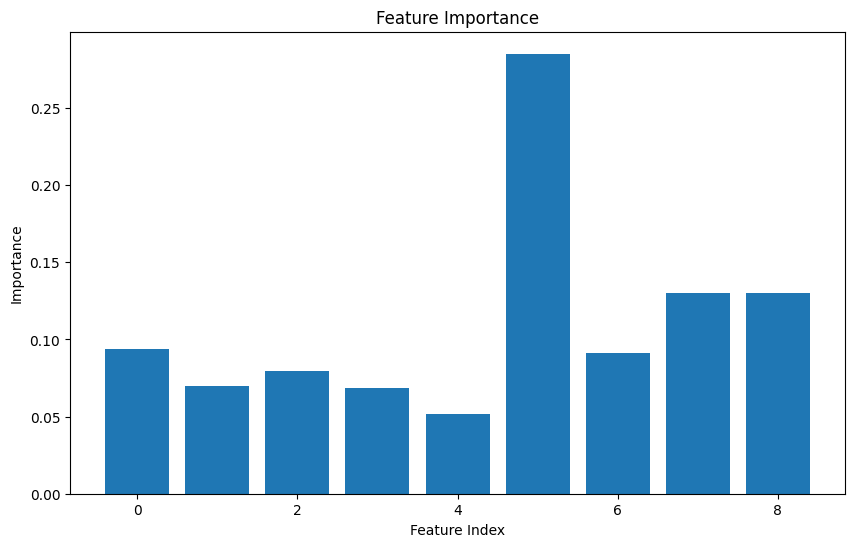

In [19]:
# Plot feature importance
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()